In [1]:
from transformers import AutoModelWithLMHead, AutoTokenizer,VisionEncoderDecoderModel, ViTFeatureExtractor,ViTImageProcessor
import torch
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import random

In [2]:
from transformers import ViTModel, GPT2LMHeadModel

In [3]:
from torch import nn

In [4]:
import cv2
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

## 0. Functions

In [5]:
max_length = 100
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(image_paths):
    images = []
    for image_path in image_paths:

        try:
            i_image = Image.open(image_path)
        except:
            return None
            
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
    
        images.append(i_image)
    
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    print(pixel_values.shape)
    pixel_values = pixel_values.to(device)
    
    output_ids = model.generate(pixel_values, **gen_kwargs)

    print(output_ids)
    
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    
    return preds

## 1. Load baseline model + basic performance check

In [6]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
for name, child in model.named_children():
        for x, y in child.named_children():
            print(name,x)

encoder embeddings
encoder encoder
encoder layernorm
encoder pooler
decoder transformer
decoder lm_head


In [8]:
model.encoder

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [9]:
model.decoder

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2Attention(
          (c_attn): Conv1D()
          (q_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation(

In [10]:
tokenizer

GPT2TokenizerFast(name_or_path='nlpconnect/vit-gpt2-image-captioning', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [55]:
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

## First model that finetunes on VIST

## Second model that finetunes on VIST + concatenates image outputs

In [117]:
enc_loaded = ViTModel.from_pretrained('./model_epoch0_encoder/')
dec_loaded = GPT2LMHeadModel.from_pretrained('./model_epoch0_decoder_2imgs/')

enc_loaded.eval()
dec_loaded.eval()

model_loaded = VisionEncoderDecoderModel(encoder = enc_loaded, decoder = dec_loaded)

## Third model that finetunes on VIST + concatenates image and text (TBD)

## 2. Load VIST images

    Loading is slightly different from the previous notebook, as the entire set of images for one story together

## Train

In [11]:
ann = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/annotations")
labels = open("/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/annotations/StoriesFin.json")
labels = json.load(labels)
labels["16"]

{'sent_ids': ['80', '81', '82', '83', '84'],
 'img_ids': ['181647714', '181626113', '181645575', '181635518', '181640606'],
 'album_id': '72157594187037689',
 'text': ['we took a nice hike into the forest today .',
  'we were lucky enough to see some wildlife , like this deer .',
  'this guy was friendly . he must hit up all the hikers for food .',
  "i 'm glad we spotted this snake before we got too close !",
  'the end of our hike rewarded us with an amazing view of the falls !']}

In [12]:
len(labels.keys())

5149

In [13]:
labels['16']

{'sent_ids': ['80', '81', '82', '83', '84'],
 'img_ids': ['181647714', '181626113', '181645575', '181635518', '181640606'],
 'album_id': '72157594187037689',
 'text': ['we took a nice hike into the forest today .',
  'we were lucky enough to see some wildlife , like this deer .',
  'this guy was friendly . he must hit up all the hikers for food .',
  "i 'm glad we spotted this snake before we got too close !",
  'the end of our hike rewarded us with an amazing view of the falls !']}

In [14]:
# stories = random.sample(list(labels.keys()),100) # choose 100 random stories

In [15]:
labels['16']

{'sent_ids': ['80', '81', '82', '83', '84'],
 'img_ids': ['181647714', '181626113', '181645575', '181635518', '181640606'],
 'album_id': '72157594187037689',
 'text': ['we took a nice hike into the forest today .',
  'we were lucky enough to see some wildlife , like this deer .',
  'this guy was friendly . he must hit up all the hikers for food .',
  "i 'm glad we spotted this snake before we got too close !",
  'the end of our hike rewarded us with an amazing view of the falls !']}

In [16]:
train = {}
for s in labels:
    for idx, im in enumerate(labels[s]['img_ids']):
        image_path = f"/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/{im}.jpeg"
        key = f"story_{s}"
        if key not in train:
            train[key] = {}
        train[key][idx] = {}
        train[key][idx]['image_path'] = image_path
        train[key][idx]['text'] = labels[s]['text'][idx]

    # train[s] = {}
    # train[s]["image_paths"] = []
    # train[s]["img_ids"] = labels[s]['img_ids']
    # train[s]["text"] = labels[s]['text']    
    # for im in train[s]["img_ids"]:
    #     train[s]["image_paths"].append(f"/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/{im}.jpeg")

In [17]:
train['story_16']

{0: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181647714.jpeg',
  'text': 'we took a nice hike into the forest today .'},
 1: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181626113.jpeg',
  'text': 'we were lucky enough to see some wildlife , like this deer .'},
 2: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181645575.jpeg',
  'text': 'this guy was friendly . he must hit up all the hikers for food .'},
 3: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181635518.jpeg',
  'text': "i 'm glad we spotted this snake before we got too close !"},
 4: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181640606.jpeg',
  'text': 'the end of our hike rewarded us with an amazing view of the falls !'}}

In [18]:
len(train.keys())

5149

In [19]:
print(list(train.keys())[2])
train[list(train.keys())[2]]

story_19


{0: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181647714.jpeg',
  'text': 'giant sequoia tree and red woods in the forest .'},
 1: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181626113.jpeg',
  'text': 'a young deer scampers about in the woods .'},
 2: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181645575.jpeg',
  'text': 'grey squirrel holding some food with his paws .'},
 3: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181635518.jpeg',
  'text': 'the snake slithers quietly through the underbrush .'},
 4: {'image_path': '/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181640606.jpeg',
  'text': 'beautiful picture taken of a river running through the valley .'}}

In [20]:
os.path.exists('/home/jay.je/IMspiredStoryTelling/datasets/VIST/train/images/181640606.jpeg')

True

In [24]:
print(len(train))

5149


In [35]:
class CustomImageDataset(Dataset):
    
    def __init__(self, stories_annotations, img_dir=None, transform=None, target_transform=None):
        # self.img_labels = annotations_file
        # self.img_dir = img_dir
        self.stories = stories_annotations
        self.stories_keys = list(stories_annotations.keys())
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        """Returns the number of samples in our dataset
        """
        return len(list(self.stories.keys()))

    def __getitem__(self, idx):

        if idx >= self.__len__():
            return
        story_num = self.stories_keys[idx]
        
        # get label
        # label = self.stories[story_num]['text']
        # label = tokenizer(label, padding="max_length").input_ids # omitted max_target_lengths
        # label = torch.tensor(label).squeeze()
        inputs = {}
        imgs = []
        labs = []
        atts = []
        print(f"getting {story_num}...")

        try:
            prev_img = None
            
            for seq in self.stories[story_num]:
                img_source = self.stories[story_num][seq]['image_path']
                img = read_image(img_source)
                img = feature_extractor(images=img, return_tensors="pt").pixel_values.squeeze()
                imgs.append(img.clone().detach())
                
                lab_source = self.stories[story_num][seq]['text']
                
                tok_out = tokenizer(lab_source, padding="max_length")
                lab = tok_out.input_ids
                lab = torch.tensor(lab).squeeze()
                labs.append(lab.clone().detach())

                att = tok_out.attention_mask
                att = torch.tensor(att).squeeze()
                atts.append(att.clone().detach())

                
            inputs['pixel_values'] = torch.stack(imgs)
            inputs['labels'] = torch.stack(labs)
            inputs['attention_mask'] = torch.stack(atts)
            
        except:
            return self.__getitem__(idx+1)
        
        return inputs

In [37]:
custom_train_data = CustomImageDataset(train)
train_dataloader = DataLoader(custom_train_data, batch_size=1, shuffle=True) # , collate_fn=my_collate

## (KEY PART OF THIS NOTEBOOK)Try to do generation!

### Check if I can feed in encoder output directly
    YES! Can feed in different prior encoder states

In [25]:
img1 = read_image(train['story_16'][0]['image_path'])
img2 = read_image(train['story_16'][1]['image_path'])

In [26]:
lab1 = train['story_16'][0]['text']
lab2 = train['story_16'][1]['text']

Text(0.5, 1.0, 'we took a nice hike into the forest today .')

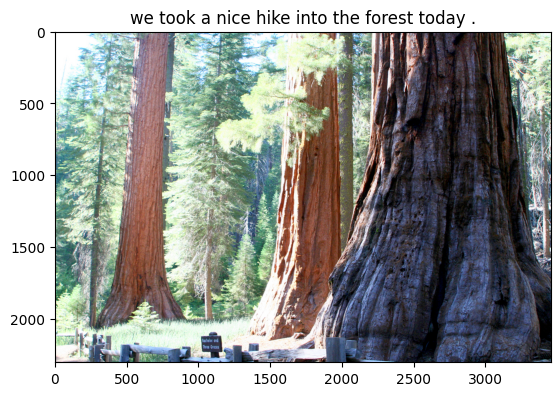

In [27]:
newimg1 = torch.swapaxes(img1, 0,2)
newimg1 = torch.swapaxes(newimg1, 0,1)
plt.imshow(np.array(newimg1))
plt.title(lab1)

Text(0.5, 1.0, 'we were lucky enough to see some wildlife , like this deer .')

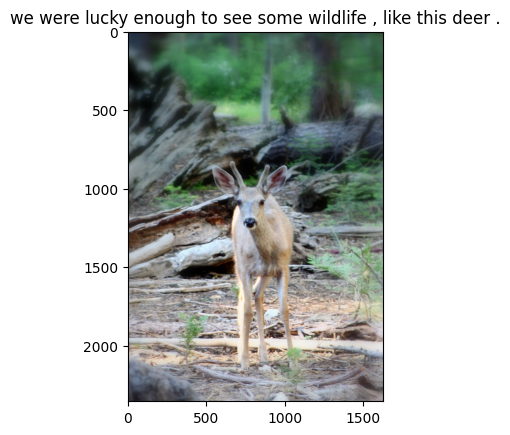

In [28]:
newimg2 = torch.swapaxes(img2, 0,2)
newimg2 = torch.swapaxes(newimg2, 0,1)
plt.imshow(np.array(newimg2))
plt.title(lab2)

In [39]:
output = next(iter(train_dataloader))

getting story_28898...


In [41]:
output.keys()

dict_keys(['pixel_values', 'labels', 'attention_mask'])

In [45]:
output['pixel_values'][0][0].shape

torch.Size([3, 224, 224])

In [97]:
def get_model_generation(model, custom_loader):


    ls_out = []

    output = next(iter(custom_loader))

    prev_enc = None
    for i in range(5):
        pix = output['pixel_values'][0][i].unsqueeze(0).to(device)
        att = output['attention_mask'][0][i].unsqueeze(0).to(device)

        print(f"{i}th image")
        print(pix.shape)
        print(att.shape)

        enc_out = model.encoder(pix)
        
        if prev_enc != None:
            enc_out.last_hidden_state = torch.concat((prev_enc, enc_out.last_hidden_state),1)
        
        else:
            enc_out.last_hidden_state = torch.concat((enc_out.last_hidden_state, enc_out.last_hidden_state),1)

        print("at prev enc stage")
        prev_enc = enc_out.last_hidden_state

        print("outout state")
        outputids = model.generate(encoder_outputs=enc_out, attention_mask = att, **gen_kwargs)

        print(tokenizer.batch_decode(outputids))
        ls_out.append(outputids) 
    
    return ls_out

In [98]:
outputs = get_model_generation(model, train_dataloader)

getting story_28064...
0th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|>a red brick building with a large window <|endoftext|>']
1th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|>a large building with a large clock on the side of it <|endoftext|>']
2th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|>a large building with a clock on the side of it <|endoftext|>']
3th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|>a large building with a clock on the front of it <|endoftext|>']
4th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|>a large building with a clock on the side of it <|endoftext|>']


In [109]:
img1 = read_image(train['story_28064'][0]['image_path'])
img2 = read_image(train['story_28064'][1]['image_path'])
lab1 = train['story_28064'][0]['text']
lab2 = train['story_28064'][1]['text']

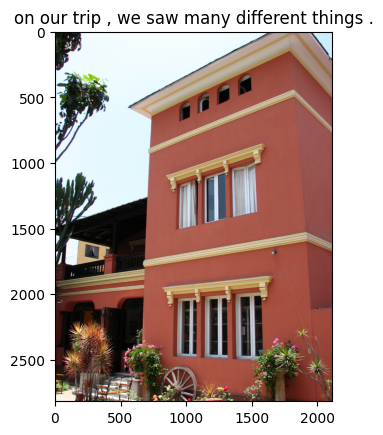

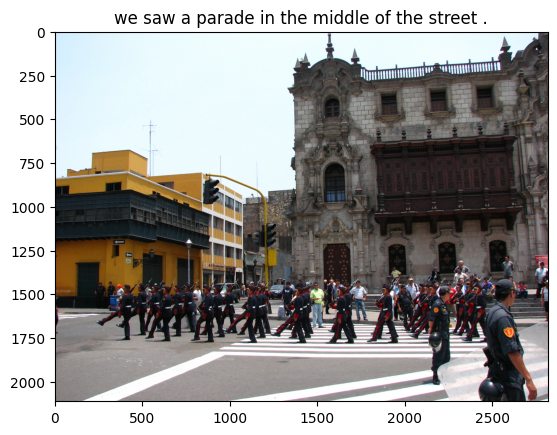

In [110]:
newimg1 = torch.swapaxes(img1, 0,2)
newimg1 = torch.swapaxes(newimg1, 0,1)
plt.imshow(np.array(newimg1))
plt.title(lab1)
plt.show()

newimg2 = torch.swapaxes(img2, 0,2)
newimg2 = torch.swapaxes(newimg2, 0,1)
plt.imshow(np.array(newimg2))
plt.title(lab2)
plt.show()

## Now load the trained model to see if it works!

In [113]:
model_loaded

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [118]:
model_loaded.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [119]:
outputs_loaded = get_model_generation(model_loaded, train_dataloader)

getting story_15406...
0th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|><|endoftext|>']
1th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|><|endoftext|>']
2th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|><|endoftext|>']
3th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|><|endoftext|>']
4th image
torch.Size([1, 3, 224, 224])
torch.Size([1, 1024])
at prev enc stage
outout state
['<|endoftext|><|endoftext|>']


In [328]:
# original version
sam_outputids1_l = model_loaded.generate(encoder_outputs=enc_out1, attention_mask = att, **gen_kwargs)
sam_outputids2_l = model_loaded.generate(encoder_outputs=enc_out2, attention_mask = att, **gen_kwargs)
org_outputids1_l = model_loaded.generate(encoder_outputs=org_out1, attention_mask = att, **gen_kwargs)
org_outputids2_l = model_loaded.generate(encoder_outputs=org_out2, attention_mask = att, **gen_kwargs)

In [338]:
print(tokenizer.batch_decode(sam_outputids1_l)[0])
print(tokenizer.batch_decode(sam_outputids2_l)[0])

<|endoftext|>snow covered trees and trees in the woods... it was a great day...<|endoftext|>
<|endoftext|> was it really that hard to find a place to sleep in the woods.<|endoftext|>


In [339]:
print(tokenizer.batch_decode(org_outputids1_l)[0])
print(tokenizer.batch_decode(org_outputids2_l)[0])

<|endoftext|>snow covered trees and trees in the woods... it was a great day...<|endoftext|>
<|endoftext|> was it really that hard to find the location of the location...?<|endoftext|>


In [340]:
## It does! in a weird way